In [97]:
!pip install TPOT

  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11955 sha256=faa094669cdc7e4fa910842a0a3e1fcb4a54a864d8b13cb80c94b421d0ac0618
  Stored in directory: c:\users\kakin\appdata\local\pip\cache\wheels\a8\bb\8f\6b9328d23c2dcedbfeb8498b9f650d55d463089e3b8fc0bfb2
Successfully built stopit


In [118]:
#import libraries
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import datetime 

# import missingno as msn
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import roc_curve

In [2]:
# load the json file
data = json.load(open('logins.json', 'r'))

In [3]:
# Convert to dataframe
df = pd.DataFrame(data)

# check the shape of the data
df.shape

(93142, 1)

In [4]:
#Checking if there are missing values
df.isnull().sum().sum()
df.head()

login_time
0  1970-01-01 20:13:18
1  1970-01-01 20:16:10
2  1970-01-01 20:16:37
3  1970-01-01 20:16:36
4  1970-01-01 20:26:21

In [5]:
#Checking the data summary
df.describe()

login_time
count                 93142
unique                92265
top     1970-04-04 01:17:40
freq                      3

In [6]:
#set log_time as index
df = df.set_index(['login_time'])

# Convert the index to datetime
df.index = pd.to_datetime(df.index)

# creating a new column 'Count' and assigning 1 to it.
df['count'] = 1

In [7]:
# Resampling the data to 15minute time intervals
df_resample = df.resample('15T', loffset = '15min').sum()
df_resample.head(5)

<ipython-input-7-33a0c38925a2>:2: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  df_resample = df.resample('15T', loffset = '15min').sum()


count
login_time                
1970-01-01 20:15:00      2
1970-01-01 20:30:00      6
1970-01-01 20:45:00      9
1970-01-01 21:00:00      7
1970-01-01 21:15:00      1

In [8]:
# Checking the shape of the resampled data
df_resample.shape

(9788, 1)

In [9]:
# Checking the info of the resampled data
df_resample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:15:00 to 1970-04-13 19:00:00
Freq: 15T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   9788 non-null   int64
dtypes: int64(1)
memory usage: 152.9 KB


In [10]:
# Checking the first 5 rows of the resampled data
df_resample.head()

count
login_time                
1970-01-01 20:15:00      2
1970-01-01 20:30:00      6
1970-01-01 20:45:00      9
1970-01-01 21:00:00      7
1970-01-01 21:15:00      1

In [11]:
df_resample['date_time'] = df_resample.index
df_resample.head()

count           date_time
login_time                                    
1970-01-01 20:15:00      2 1970-01-01 20:15:00
1970-01-01 20:30:00      6 1970-01-01 20:30:00
1970-01-01 20:45:00      9 1970-01-01 20:45:00
1970-01-01 21:00:00      7 1970-01-01 21:00:00
1970-01-01 21:15:00      1 1970-01-01 21:15:00

In [12]:
df_resample['date_time'] = pd.to_datetime(df_resample['date_time'])

In [13]:
# Extracting the day, year, month, and time from date_time column
df_resample['year'] = df_resample['date_time'].dt.year
df_resample['month'] = df_resample['date_time'].dt.month
df_resample['time'] = df_resample['date_time'].dt.time
df_resample['day'] = df_resample['date_time'].dt.day
df_resample['weekday'] = df_resample['date_time'].dt.weekday
df_resample['hour'] = df_resample['date_time'].dt.hour

In [14]:
df_resample.head()

count           date_time  year  month      time  day  \
login_time                                                                   
1970-01-01 20:15:00      2 1970-01-01 20:15:00  1970      1  20:15:00    1   
1970-01-01 20:30:00      6 1970-01-01 20:30:00  1970      1  20:30:00    1   
1970-01-01 20:45:00      9 1970-01-01 20:45:00  1970      1  20:45:00    1   
1970-01-01 21:00:00      7 1970-01-01 21:00:00  1970      1  21:00:00    1   
1970-01-01 21:15:00      1 1970-01-01 21:15:00  1970      1  21:15:00    1   

                     weekday  hour  
login_time                          
1970-01-01 20:15:00        3    20  
1970-01-01 20:30:00        3    20  
1970-01-01 20:45:00        3    20  
1970-01-01 21:00:00        3    21  
1970-01-01 21:15:00        3    21

In [15]:
# Aggregating month by count
df_resample_month_count = df_resample.groupby('month')['count'].sum()
df_resample_month_count.head()

month
1    21225
2    24669
3    33727
4    13521
Name: count, dtype: int64

(array([0, 1, 2, 3]),
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

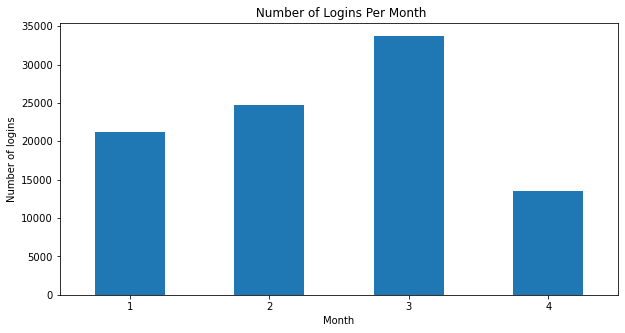

In [16]:
# Using Bar Graph to check monthly count
df_resample_month_count.plot(kind='bar', figsize=(10,5));
plt.title(" Number of Logins Per Month")
plt.xlabel("Month")
plt.ylabel("Number of logins")
plt.xticks(rotation=0)

***Looking at the bar graph above, it is obvious that the highest number of logins appear in the third month which is the month of March while the month of april has the lowest number of logins.***

In [17]:
# Aggregating weekday by count to get number of logins per weekday
df_resample_weekday_count = df_resample.groupby('weekday')['count'].sum()
df_resample_weekday_count.head()

weekday
0     8849
1     9226
2    10282
3    11951
4    15152
Name: count, dtype: int64

[Text(0, 0, 'Monday'),
 Text(1, 0, 'Tuesday'),
 Text(2, 0, 'Wednesday'),
 Text(3, 0, 'Thursday'),
 Text(4, 0, 'Friday'),
 Text(5, 0, 'Saturday'),
 Text(6, 0, 'Sunday')]

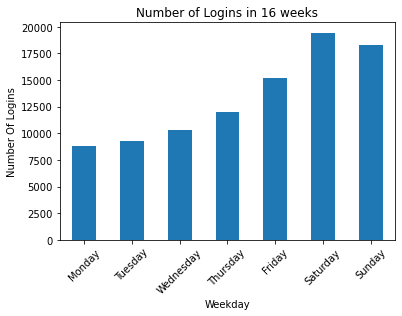

In [18]:
import calendar

# Plot bar graph
ax = df_resample_weekday_count.plot(kind='bar');
plt.title("Number of Logins in 16 weeks")
plt.xlabel("Weekday")
plt.ylabel("Number Of Logins")
plt.xticks(rotation=45)
ax.set_xticklabels([calendar.day_name[d] for d in range(7)])

No of login per weekday
weekday
0     553.0625
1     576.6250
2     642.6250
3     746.9375
4     947.0000
5    1214.6250
6    1140.5000
Name: count, dtype: float64


[Text(0, 0, 'Monday'),
 Text(1, 0, 'Tuesday'),
 Text(2, 0, 'Wednesday'),
 Text(3, 0, 'Thursday'),
 Text(4, 0, 'Friday'),
 Text(5, 0, 'Saturday'),
 Text(6, 0, 'Sunday')]

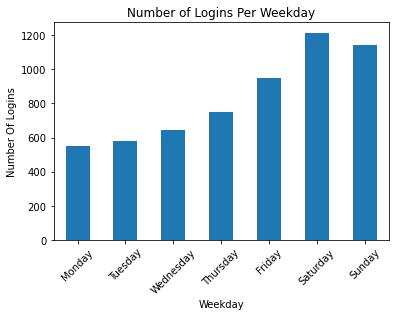

In [19]:
 # total number weeks
no_of_week = 16 

df_resample_weekday2_count = df_resample.groupby('weekday')['count'].sum()

# Average number of login per weekday
df_resample_weekday2_count = df_resample_weekday2_count/no_of_week
print('No of login per weekday' )
print(df_resample_weekday2_count)

# Plot bar graph
ax = df_resample_weekday2_count.plot(kind='bar');
plt.title("Number of Logins Per Weekday")
plt.xlabel("Weekday")
plt.ylabel("Number Of Logins")
plt.xticks(rotation=45)
ax.set_xticklabels([calendar.day_name[d] for d in range(7)])


***Looking at the bar graph, it looks like there were more logins on Saturdays than every other days. Also, there were increasing trend in the number of logins from Monday to Sunday.*** 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23')])

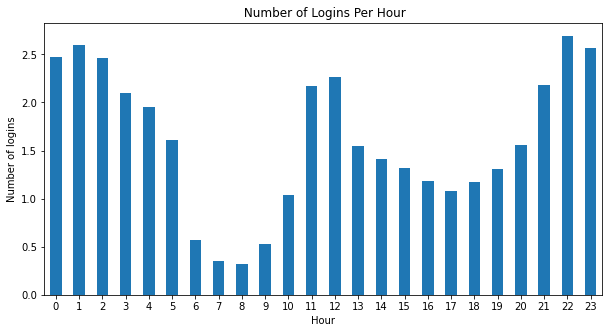

In [20]:
# Total number of hours in the 4 months period
no_of_hr = 720 + 672 + 720 + 312

df_resample_hour_count = df_resample.groupby('hour')['count'].sum()
df_resample_hour_count = df_resample_hour_count/no_of_hr
df_resample_hour_count.plot(kind='bar', figsize=(10,5))
plt.title(" Number of Logins Per Hour")
plt.xlabel("Hour")
plt.ylabel("Number of logins")
plt.xticks(rotation=0)


***There were much number of logins in the early hour of the day and late hour of the day. Although, in the middle of the day, there seems to be high number of logins similar to the early and late hours logins.***

### SUMMARY

***The summary of the analysis above indicates that the highest number of logins appear in the third month which is the month of March while the month of april has the lowest number of logins and there were more logins on Saturdays than every other days. Also, there were increasing trend in the number of logins from Monday to Sunday. It shows that more people tends login in the early hour of the day and late hour of the day as well as in the middle of the day as there seems to be high number of logins during these time period.***

# Part 2

***The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.***


***1.*** ***What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?***

***Answer:***

One thing I will consider as the key measure of success in this case is, if there exist an easy mobility to either cities at any time of the day without highly impacting the revenue due to the toll costs reimbursement. Another key measure would be for all passengers to be able to afford the fee. I believe if the fee is cheap, there will be an easy mobility.


***2.*** ***Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:***

***a) how you will implement the experiment.***

***Answer:***

First, I will set a two tail hypothesis for the groups where the null hypothesis is "driver partners is NOT available in both cities" and the alternative hypothesis is "driver partners is available in both cities". Assuming the two groups follow normal distribution, I will carry out a statistical test to test significance by comparing the p-value with the level of significance alpha. Note, I will be comparing the mean of both groups.

***b) what statistical test(s) you will conduct to verify the significance of the
observation***

***Answer:*** 
I will conduct a two-tail t-test

***c) how you would interpret the results and provide recommendations to the city
operations team along with any caveats.***

***Answer:*** 

If the p-value is smaller than the level of significance (Alpha), the null hypothesis will be rejected and the alternative hypothesis is accepted and we can conclude that availability of driver partners in both cities is effective. 



# Part 3

***Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?***


In [23]:
data2 = json.load(open('ultimate_data_challenge.json', 'r'))

df2 = pd.DataFrame(data2)
df2.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0         46.2      3.67                   5.0  
1         50.0      8.26                   5.0  
2        100.0      0.77                   5.0  
3         80.0      2.36                   4.9  
4         82.4      3.13                   4.9

# Exploring the data

In [25]:
df2.shape

(50000, 12)

In [27]:
df2.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [28]:
df2.describe()

trips_in_first_30_days  avg_rating_of_driver     avg_surge  \
count            50000.000000          41878.000000  50000.000000   
mean                 2.278200              4.601559      1.074764   
std                  3.792684              0.617338      0.222336   
min                  0.000000              1.000000      1.000000   
25%                  0.000000              4.300000      1.000000   
50%                  1.000000              4.900000      1.000000   
75%                  3.000000              5.000000      1.050000   
max                125.000000              5.000000      8.000000   

          surge_pct   weekday_pct      avg_dist  avg_rating_by_driver  
count  50000.000000  50000.000000  50000.000000          49799.000000  
mean       8.849536     60.926084      5.796827              4.778158  
std       19.958811     37.081503      5.707357              0.446652  
min        0.000000      0.000000      0.000000              1.000000  
25%        0.000000     33.300000      2.420000              4.700000  
50%        0.000000     66.700000      3.880000              5.000000  
75%        8.600000    100.000000      6.940000              5.000000  
max      100.000000    100.000000    160.960000              5.000000

In [30]:
df2.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [32]:
df2['avg_rating_by_driver'].value_counts().head(5)

5.0    28508
4.8     4537
4.7     3330
4.9     3094
4.5     2424
Name: avg_rating_by_driver, dtype: int64

# Most drivers have 5.0 rating

In [33]:
!pip install pandas-profiling==2.8.0
import pandas_profiling as pp

In [34]:
df2.profile_report()

Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [35]:
# Last trip date
df2['last_trip_date'].max()

'2014-07-01'

In [37]:
df2['trip_date_extracted'] = [x>'2014-06-01' for x in df2.last_trip_date]

In [38]:
df2['trip_date_extracted'].head()

0     True
1    False
2    False
3     True
4    False
Name: trip_date_extracted, dtype: bool

In [40]:
df2_date_retain = df2['trip_date_extracted'].value_counts()
df2_date_retain

False    31690
True     18310
Name: trip_date_extracted, dtype: int64

(array([0, 1]), [Text(0, 0, 'False'), Text(1, 0, 'True')])

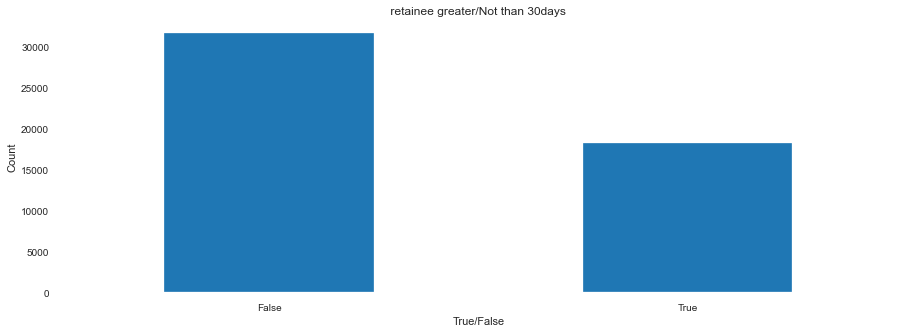

In [45]:
df2_date_retain.plot(kind='bar', figsize=(15,5));
plt.title(" retainee greater/Not than 30days ")
plt.xlabel("True/False")
plt.ylabel("Count")
plt.xticks(rotation=0)

In [ ]:
# Bar plot above shows 

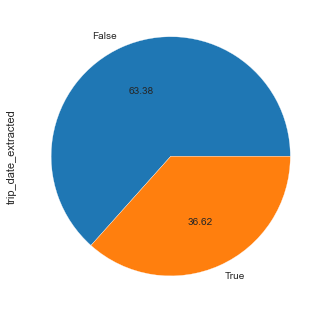

In [47]:
df2_date_retain.plot.pie(autopct='%.2f');

In [52]:
df2.groupby(['trip_date_extracted'])['city'].value_counts().unstack()

city                 Astapor  King's Landing  Winterfell
trip_date_extracted                                     
False                  12512            3823       15355
True                    4022            6307        7981

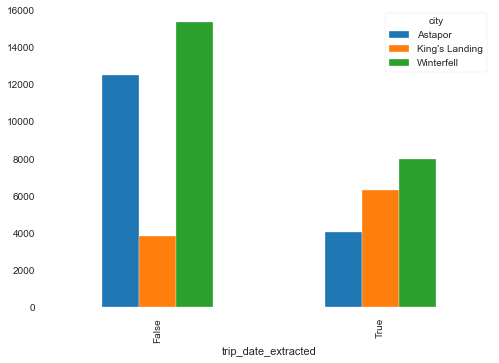

In [51]:
df2.groupby(['trip_date_extracted'])['city'].value_counts().unstack().plot.bar();


In [61]:
df2_retain_sum = df2.groupby(['trip_date_extracted'])['city'].value_counts()[0]

In [62]:
df2.groupby(['trip_date_extracted'])['city'].value_counts()[1]/df2_retain_sum

city
Astapor           0.321451
King's Landing    1.649752
Winterfell        0.519766
Name: city, dtype: float64

***In King's Landing, for every one in-active user in the last 30days, there will be approximately 1.65 active user. Whereas in Astapor, there were low user activity in the past 30days***. 

In [76]:
# To get the date of the sixth day
days_150=datetime.timedelta(days=150)

In [67]:
days_150

datetime.timedelta(days=150)

In [69]:
# Convert dates to datetime
df2['last_trip_date']=pd.to_datetime(df2['last_trip_date'])
df2['signup_date']=pd.to_datetime(df2['signup_date'])

In [72]:
df2['signup_date']

0       2014-01-25
1       2014-01-29
2       2014-01-06
3       2014-01-10
4       2014-01-27
           ...    
49995   2014-01-25
49996   2014-01-24
49997   2014-01-31
49998   2014-01-14
49999   2014-01-18
Name: signup_date, Length: 50000, dtype: datetime64[ns]

In [77]:
df2['sixth_month_date']=df2['signup_date']+days_150

In [78]:
df2['sixth_month_date']

0       2014-06-24
1       2014-06-28
2       2014-06-05
3       2014-06-09
4       2014-06-26
           ...    
49995   2014-06-24
49996   2014-06-23
49997   2014-06-30
49998   2014-06-13
49999   2014-06-17
Name: sixth_month_date, Length: 50000, dtype: datetime64[ns]

In [80]:
# User who are active with the last sixth month
df2['user_active']=np.where(df2['last_trip_date']>df2['sixth_month_date'], 1, 0)

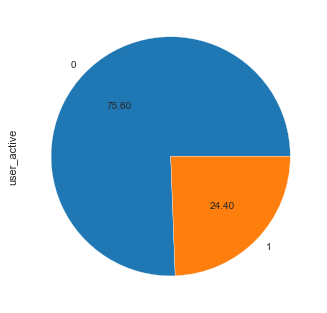

In [82]:
df2['user_active'].value_counts().plot.pie(autopct='%.2f');


***It can be seen that 24.40% percent are still active in their sixth month of sign up.*** 

In [87]:
# Coding categorical data
df2['phone']=df2['phone'].replace(['iPhone', 'Android'],[1,0])
df2['trip_date_extracted']=df2['trip_date_extracted'].replace([True, False],[1,0])
df2['ultimate_black_user']=df2['ultimate_black_user'].replace([True, False],[1,0])
df2['city']=df2['city'].replace(['Astapor',"King's Landing",'Winterfell'],[0,1,2])


In [89]:
df2['phone'].value_counts()

1.0    34582
0.0    15022
Name: phone, dtype: int64

In [85]:
df2.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'trip_date_extracted', 'sixth_month',
       'sixth_month_date', 'user_active'],
      dtype='object')

In [90]:
# Check for missing values
df2.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
trip_date_extracted          0
sixth_month                  0
sixth_month_date             0
user_active                  0
dtype: int64

In [92]:
# Dealing with missing values
# Since the missing average rating of driver will correspond to a rating, we can impute the missing values with the mean 
df2['avg_rating_of_driver'].fillna(df2['avg_rating_of_driver'].mean(), inplace=True)

# Since the missing average rating by driver will correspond to a rating, we can impute the missing values with the mean 
df2['avg_rating_by_driver'].fillna(df2['avg_rating_by_driver'].mean(), inplace=True)

# Since most drivers will have a phone, we can fill the missing values with 1
df2['phone'].fillna(1, inplace=True)


In [93]:
# No more missing values
df2.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
trip_date_extracted       0
sixth_month               0
sixth_month_date          0
user_active               0
dtype: int64

# Modeling

In [94]:
X=df2[['city', 'trips_in_first_30_days', 'avg_rating_of_driver',
       'avg_surge','phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver']]

In [95]:
y = df2['user_active']

In [99]:
# Split data into test and train set.
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=2)

# TPOT Classifier will be used to explore the best pipeline configurations

In [100]:
tpot= TPOTClassifier(generations=1,verbosity=2,random_state=42)
tpot.fit(X_train,y_train)

Optimization Progress:   0%|          | 0/200 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8002499999999999

Best pipeline: XGBClassifier(input_matrix, learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=100, n_jobs=1, subsample=0.55, verbosity=0)


TPOTClassifier(generations=1, random_state=42, verbosity=2)

In [101]:
# Model performance on the test data
print(tpot.score(X_test, y_test))

0.8012


***It appears that XGB Classifer is the best pipeline.***

In [102]:
model=XGBClassifier()
model.fit(X_train,y_train)

C:\Users\kakin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

# Using feature importance technique to check the best features

In [103]:
print(model.feature_importances_)

[0.11955029 0.0484695  0.03721412 0.04664758 0.18923897 0.13266048
 0.08602501 0.0812365  0.0320596  0.226898  ]


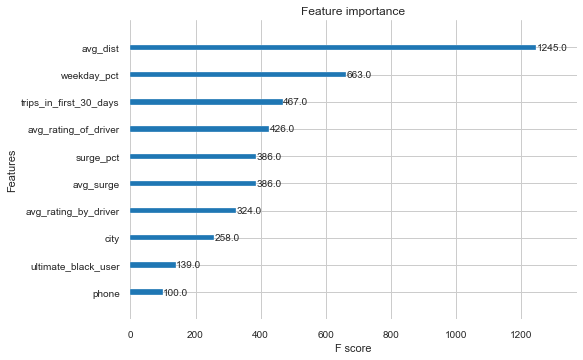

In [104]:
plot_importance(model);

The top 4 most important features are the avg_dist, weekday_pct, trips_in_first_30_days, and avg_rating_of_driver.  the average distance in miles per trip taken in the first 30 days after signup is much important in rider's retention rate. 

# Logistic Regression

In [107]:
# Tune C and penalty
clf = LogisticRegression(random_state=42)
params = {
    'C': [1e-5, 1e-4, 0.001, 0.01, 0.1],
    'penalty': ['l1', 'l2']
}
model = GridSearchCV(clf, params, scoring='accuracy')
model.fit(X_train, y_train)
print('Best parameters were', model.best_params_)
print('Best accuracy was', model.best_score_)

C:\Users\kakin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\kakin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kakin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\kakin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\kakin\anaconda3\lib\site-packages\sklearn\model_selection\_v

C:\Users\kakin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\kakin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kakin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\kakin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\kakin\anaconda3\lib\site-packages\sklearn\model_selection\_v

C:\Users\kakin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\kakin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\kakin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\kakin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Best parameters were {'C': 0.01, 'penalty': 'l2'}
Best accuracy was 0.765075


C:\Users\kakin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [114]:
logreg = LogisticRegression(C=0.0001, penalty='l2', random_state=42)
logreg.fit(X_train, y_train)
ypred = logreg.predict(X_test)
print('Accuracy of test set was {}\n'.format(accuracy_score(y_test, ypred)))
print(classification_report(y_test, ypred))
tn, fp, fn, tp = confusion_matrix(y_test, ypred).ravel()
print('True Negative = {}\tFalse Positive = {}\nFalse Negative = {}\tTrue Positive={}'
     .format(tn,fp,fn,tp))

Accuracy of test set was 0.7642

              precision    recall  f1-score   support

           0       0.77      0.99      0.86      7594
           1       0.61      0.06      0.10      2406

    accuracy                           0.76     10000
   macro avg       0.69      0.52      0.48     10000
weighted avg       0.73      0.76      0.68     10000

True Negative = 7505	False Positive = 89
False Negative = 2269	True Positive=137


C:\Users\kakin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


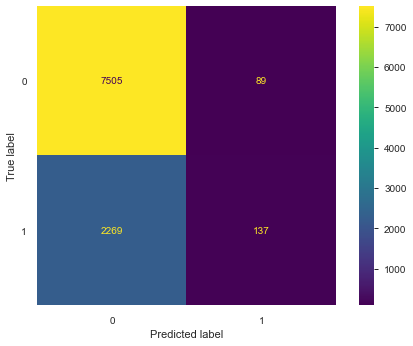

In [119]:
clf = SVC(random_state=0)
clf.fit(X_train, y_train)
SVC(random_state=0)
plot_confusion_matrix(logreg, X_test, y_test)  
plt.show()